### keras RNN으로 여행자 수 예측

**1. 패키지 수입 및 파라미터 설정**

In [1]:
# 수입
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time #학습 시간 잴 때 쓰는 함수
from sklearn.preprocessing import MinMaxScaler #,StandardScaler #데이터 정규화 함수
from keras.layers import Dense
from keras.layers import LSTM, InputLayer
from keras.models import Sequential #인공 신경망 구현 방식
from sklearn.model_selection import train_test_split #학습, 평가 4분할해주는 함수

In [2]:
# RNN 파라미터
MY_PAST =12
MY_SPLIT = 0.8 #8대3으로 나눔
MY_HIDDEN = 300 #은닉층, LSTM 안에 몇개의 뉴런을 사용할 것인지
MY_SHAPE = (MY_PAST, 1) #쉐입은 괄호안에 #Q : ,1이 왜 필요한지? A : RNN설계도에서 확인, 각각의 독립된 차원으로 들어와야해서 = 2차원으로 들어와야해서 
MY_EPOCH = 300

**2. 데이터 처리**

In [3]:
# 데이터 읽기
raw = pd.read_csv('/content/drive/MyDrive/data/airline.csv',
                  header=None, # 크라임 같은 영향을 주는 요소가 존재하지 않기 때문에 오류를 방지하기 위해 사용
                  usecols=[1]) # 1번째 컬럼 사용할 거다.

# 샘플 출력
print(raw.head(15))
print(raw.describe()) #함수니까 () 추가

      1
0   112
1   118
2   132
3   129
4   121
5   135
6   148
7   148
8   136
9   119
10  104
11  118
12  115
13  126
14  141
                1
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


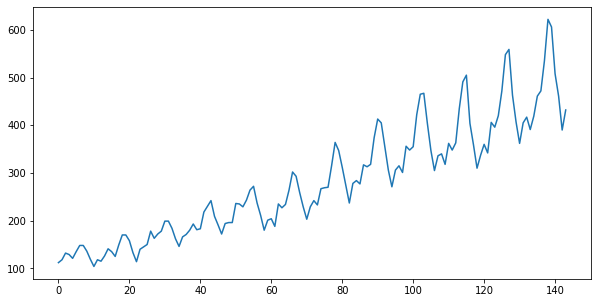

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(raw)

<class 'numpy.ndarray'>
[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]
 [0.04247104]
 [0.07142857]
 [0.05984556]
 [0.04054054]
 [0.08687259]
 [0.12741313]
 [0.12741313]
 [0.1042471 ]
 [0.05598456]
 [0.01930502]
 [0.06949807]
 [0.07915058]
 [0.08880309]
 [0.14285714]
 [0.11389961]
 [0.13127413]
 [0.14285714]
 [0.18339768]
 [0.18339768]
 [0.15444015]
 [0.11196911]
 [0.08108108]
 [0.11969112]
 [0.12934363]
 [0.14671815]
 [0.17181467]
 [0.14864865]
 [0.15250965]
 [0.22007722]
 [0.24324324]
 [0.26640927]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374517]
 [0.17760618]
 [0.17760618]
 [0.25482625]
 [0.25289575]
 [0.24131274]
 [0.26833977]
 [0.30888031]
 [0.32432432]
 [0.25675676]
 [0.20656371]
 [0.14671815]
 [0.18725869]
 [0.19305019]
 [0.16216216]
 [0.25289575]
 [0.23745174]
 [0.25096525]
 [0.30888031]
 [0.38223938]
 [0.36486486]
 [0.2992278 ]
 [0.241312

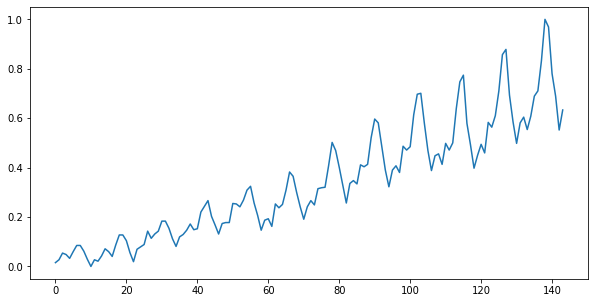

In [5]:
# 데이터 정규화
scaler = MinMaxScaler() #범위를 0~1로 바꿈 
#scaler = StandardScaler()
s_data = scaler.fit_transform(raw) 
#s_data = s_data*2 - 0.5 (범위 [-1, 1]로 바꾸기)

print(type(s_data)) #numpy로 나옴
print(s_data)
print(s_data.flatten()) # numpy는 flatten()사용 가능
plt.figure(figsize=(10, 5))
plt.plot(s_data)

In [6]:
# 데이터 분할
data =[]
for i in range(len(s_data) - MY_PAST) : #len(s_data)=12, MY_PAST=12, 144-12=132
    data.append(s_data[i: i + MY_PAST + 1]) #[i=0 : 0+MY_PAST+1], append가 data에 넣으라는 명령어

print('한 묶음의 크기: ', len(data[0]))
print('총 묶음 수: ', len(data))
print('첫번째 묶음 내용\n', data[0])
print('두번째 묶음 내용\n', data[1])

한 묶음의 크기:  13
총 묶음 수:  132
첫번째 묶음 내용
 [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]]
두번째 묶음 내용
 [[0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]
 [0.04247104]]


In [7]:
# 데이터를 numpy로 전환
print(type(data))
data = np.array(data) #numpy로 전환하기
print(type(data))

# 묶음들을  임의로 섞음
#np.random.shuffle(data)
print(data.shape)
#print(data)

# 데이터를 입력과 출력으로 분할
X_data = data[:, 0:MY_PAST] #[총 행, 총 열], :첨부터 끝까지 취한다
Y_data = data[:, -1] #행은 다취하고 열은 맨 마지막만 취한다

print('입력 데이터의 모양:', X_data.shape) #3차원 유지되고 있음
print('출력 데이터의 모양:', Y_data.shape)


<class 'list'>
<class 'numpy.ndarray'>
(132, 13, 1)
입력 데이터의 모양: (132, 12, 1)
출력 데이터의 모양: (132, 1)


In [8]:
# 데이터 4분할
X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                    Y_data,
                                                    train_size=MY_SPLIT,
                                                    shuffle=False)

# 최종 데이터 모양 출력
print('학습용 입력 데이터 모양: ', X_train.shape)
print('학습용 출력 데이터 모양: ', Y_train.shape)
print('평가용 입력 데이터 모양: ', X_test.shape)
print('평가용 출력 데이터 모양: ', Y_test.shape)


학습용 입력 데이터 모양:  (105, 12, 1)
학습용 출력 데이터 모양:  (105, 1)
평가용 입력 데이터 모양:  (27, 12, 1)
평가용 출력 데이터 모양:  (27, 1)


**3. 인공 신경망 구현**

In [9]:
# RNN 구현
model = Sequential()

model.add(InputLayer(input_shape=MY_SHAPE)) #입력층 설정 #입력층은 서머리에 포함안됨

model.add(LSTM(units=MY_HIDDEN)) #LSTM안의 은닉층 설정

model.add(Dense(units=1,
                activation='sigmoid')) #마지막 Dense 은닉층 설정, 활성화 함수 설정 #범위 [-1, 1]로 바꾸면 tanh으로 활성화 함수 변경

print('RNN 요약')
model.summary()

RNN 요약
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


**4. 인공 신경망 학습**

In [10]:
# RNN 학습 설정
model.compile(optimizer='rmsprop',
              loss='msle')    #손실 함수 
              
print('학습 시작')
begin = time()

model.fit(x=X_train,
          y=Y_train,
          epochs=MY_EPOCH,
          verbose=0)

end = time()
print('학습 시간: {:.2f}'.format(end - begin))

학습 시작
학습 시간: 7.55


**5. 인공 신경망 평가**

In [11]:
# RNN 평가
score = model.evaluate(x=X_test,
                       y=Y_test,
                       verbose=0)

print('최종 손실값: ', score)


최종 손실값:  0.0038223585579544306


**6. 인공 신경망 예측**

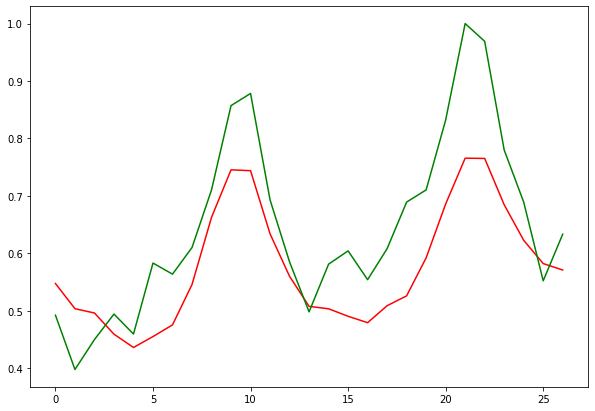

In [12]:
# RNN으로 예측
pred = model.predict(x=X_test)

# 예측 결과 및 정답 그래프 그리기
plt.figure(figsize=(10, 7))
plt.plot(pred, 'r')
plt.plot(Y_test, 'g')

In [13]:
print('역전환 전: ', pred)
print(pred.shape)

# 데이터 역전환 (압축했던 데이터를 다시 펴줌)
pred = scaler.inverse_transform(pred)

print('역전환 후: ', pred)
print(pred.shape)

# squeeze 결과
tmp = np.squeeze(pred).astype(int) #astype은 정수형으로 만듦
print('squeeze 후: ', tmp) #2차원에서 1차원으로 줄이기
print(tmp.shape)


역전환 전:  [[0.5474313 ]
 [0.50355023]
 [0.49607328]
 [0.45919603]
 [0.4360338 ]
 [0.4550315 ]
 [0.4753715 ]
 [0.54562503]
 [0.66265047]
 [0.7453533 ]
 [0.74388105]
 [0.63393885]
 [0.5598665 ]
 [0.5076368 ]
 [0.5033967 ]
 [0.49034533]
 [0.47919393]
 [0.50878495]
 [0.5259419 ]
 [0.5921293 ]
 [0.68583155]
 [0.76562846]
 [0.76521224]
 [0.6845899 ]
 [0.6226916 ]
 [0.58213747]
 [0.5709134 ]]
(27, 1)
역전환 후:  [[387.56943]
 [364.83902]
 [360.96594]
 [341.86356]
 [329.8655 ]
 [339.70633]
 [350.24243]
 [386.6338 ]
 [447.25296]
 [490.09302]
 [489.33038]
 [432.38034]
 [394.01086]
 [366.95587]
 [364.7595 ]
 [357.99887]
 [352.22247]
 [367.55063]
 [376.43793]
 [410.723  ]
 [459.26074]
 [500.59555]
 [500.37994]
 [458.61758]
 [426.55426]
 [405.5472 ]
 [399.73315]]
(27, 1)
squeeze 후:  [387 364 360 341 329 339 350 386 447 490 489 432 394 366 364 357 352 367
 376 410 459 500 500 458 426 405 399]
(27,)


역전환 전 정답 :  [[0.49227799]
 [0.3976834 ]
 [0.44980695]
 [0.49420849]
 [0.45945946]
 [0.58301158]
 [0.56370656]
 [0.61003861]
 [0.71042471]
 [0.85714286]
 [0.87837838]
 [0.69305019]
 [0.58494208]
 [0.4980695 ]
 [0.58108108]
 [0.6042471 ]
 [0.55405405]
 [0.60810811]
 [0.68918919]
 [0.71042471]
 [0.83204633]
 [1.        ]
 [0.96911197]
 [0.77992278]
 [0.68918919]
 [0.55212355]
 [0.63320463]]
역전환 후 정답:  [[359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]
 [472.]
 [548.]
 [559.]
 [463.]
 [407.]
 [362.]
 [405.]
 [417.]
 [391.]
 [419.]
 [461.]
 [472.]
 [535.]
 [622.]
 [606.]
 [508.]
 [461.]
 [390.]
 [432.]]


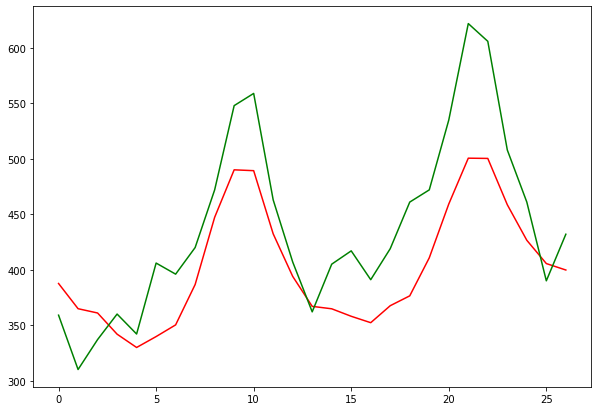

In [14]:
# 정답 출력
print('역전환 전 정답 : ', Y_test)
Y_test= scaler.inverse_transform(Y_test)
print('역전환 후 정답: ', Y_test)

# 예측 결과 및 정답 그래프 그리기
plt.figure(figsize=(10, 7))
plt.plot(pred, 'r')
plt.plot(Y_test, 'g')